# Deep Learning-CNN based hand gesture recognition

This project involves building a 3D Convolutional Neural Network (CNN) to correctly recognize hand gestures by a user to control a smart TV.

The objective of this projects is to build a hand gesture recognition model that can be hosted on a camera installed in a smart TV that can understand 5 gestures. Namely, leftwards hand movement to go to previous channel, rightward hand movement to go to next channel, upward hand movement to increase the volume, downward hand movement to decrease the volume and a palm gesture to pause playing the video. 

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount= True)
root_path = 'gdrive/MyDrive/Gesture_Recognition/'

Mounted at /content/gdrive


In [2]:
!unzip gdrive/MyDrive/Gesture_Recognition/Project_data.zip

Streaming output truncated to the last 5000 lines.
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00050.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00052.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00054.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00056.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00058.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00060.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00062.png  
   creating: Project_data/train/WIN_20180926_17_35_12_Pro_Thumbs_Down_new/
 extracting: Project_data/train/WIN_20180926_17_35_12_Pro_Thumbs_Down_new/WIN_20180926_17_35_12_Pro_00001.png  
 extracting: Project_data/t

In [3]:
import numpy as np
import os
from  imageio import imread
import cv2
import datetime
import warnings
warnings.filterwarnings('ignore')

We set the random seed so that the results don't vary drastically.

In [4]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf

# Operations that rely on a random seed actually derive it from two seeds: the graph-level and operation-level seeds. This sets the graph-level seed.
# Using global-level seed

tf.random.set_seed(30)

In this block, folder names for training and validation are read. We also set the `batch_size` here. We set the batch size in such a way that we are able to use the GPU in full capacity. We keep increasing the batch size until the machine throws an error.

In [5]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
batch_size = 32 #experiment with the batch size

## Generator
In the generator, we are going to preprocess the images as we have images of 2 different dimensions as well as create a batch of video frames.

In [6]:
def generator(source_path, folder_list, batch_size):

    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29] #create a list of image numbers you want to use for a particular video

    x = len(img_idx)
    y = 84
    z = 84

    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)/batch_size) # calculate the number of batches

        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5))  # batch_labels is the one hot representation of the output

            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder

                for idx,item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes

                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(y,z)).astype(np.float32)
                    else:
                        image = cv2.resize(image,(y,z)).astype(np.float32)
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255.0 # - 104
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255.0 # - 117
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255.0 # - 123
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1 #you yield the batch_data and the batch_labels, remember what does yield do
            yield batch_data, batch_labels # write the code for the remaining data points which are left after full batches

        if (len(t)%batch_size) != 0:

            batch_data = np.zeros((len(t)%batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((len(t)%batch_size,5)) # batch_labels is the one hot representation of the output

            for folder in range(len(t)%batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])

                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes

                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(y,z)).astype(np.float32)
                    else:
                        image = cv2.resize(image,(y,z)).astype(np.float32)

                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255.0 #- 104 
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255.0 #- 117
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255.0 #- 123

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

In [7]:
curr_dt_time = datetime.datetime.now()

train_path = 'Project_data/train'
val_path = 'Project_data/val'

num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)

num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

num_epochs = 30
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 30


## Model
A model is created using different functionalities that Keras provides.

In [8]:
from keras.models import Sequential
from keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

model = Sequential()
model.add(Conv3D(64, (3,3,3), strides=(1,1,1), padding='same', input_shape=(18,84,84,3)))
#model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2,2,1), strides=(2,2,1)))

model.add(Conv3D(128, (3,3,3), strides=(1,1,1), padding='same'))
#model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2,2,1), strides=(2,2,1)))

model.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same'))
#model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2,2,1), strides=(2,2,1)))

model.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same'))
#model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2,2,1), strides=(2,2,1)))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='elu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

Now compiling the model and looking at the summary to find out the number of parameters of the model. The number of parameters of the model is important since the model has to be light enough to be hosted on a webcam itself.

In [9]:

optimizer = optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.7, nesterov=True)

#optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)

#optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.001, initial_accumulator_value=0.1, epsilon=1e-07)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 18, 84, 84, 64)    5248      
_________________________________________________________________
activation (Activation)      (None, 18, 84, 84, 64)    0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 9, 42, 84, 64)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 9, 42, 84, 128)    221312    
_________________________________________________________________
activation_1 (Activation)    (None, 9, 42, 84, 128)    0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 4, 21, 84, 128)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 4, 21, 84, 256)    8

Creating the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [10]:
train_generator = generator(train_path, train_doc, batch_size)

val_generator = generator(val_path, val_doc, batch_size)

In [11]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False, 
                             mode='auto', 
                             period=1)

LR = ReduceLROnPlateau(monitor='val_loss', 
                       factor=0.5, 
                       patience=2, 
                       verbose=1, 
                       mode='min', 
                       min_delta=0.0001, 
                       cooldown=0, 
                       min_lr=0.00001)

callbacks_list = [checkpoint, LR]

In [12]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Fitting the model and saving checkpoints.

In [13]:
Model_1= model.fit(train_generator, 
          steps_per_epoch=steps_per_epoch, 
          epochs=num_epochs, 
          verbose=1, 
          callbacks=callbacks_list, 
          validation_data=val_generator, 
          validation_steps=validation_steps, 
          class_weight=None, 
          workers=1, 
          initial_epoch=0)

Source path =  Project_data/train ; batch size = 32
Epoch 1/30
21/21 [==============================] - 94s 2s/step - loss: 1.6181 - categorical_accuracy: 0.2475 - val_loss: 1.5536 - val_categorical_accuracy: 0.3900

Epoch 00001: val_loss improved from inf to 1.55357, saving model to model_init_2021-06-1413_35_22.463087/model-00001-1.61910-0.23529-1.55357-0.39000.h5
Epoch 2/30
21/21 [==============================] - 40s 2s/step - loss: 1.5842 - categorical_accuracy: 0.2549 - val_loss: 1.5408 - val_categorical_accuracy: 0.2700

Epoch 00002: val_loss improved from 1.55357 to 1.54083, saving model to model_init_2021-06-1413_35_22.463087/model-00002-1.57471-0.29110-1.54083-0.27000.h5
Epoch 3/30
21/21 [==============================] - 38s 2s/step - loss: 1.5421 - categorical_accuracy: 0.3158 - val_loss: 1.4888 - val_categorical_accuracy: 0.5200

Epoch 00003: val_loss improved from 1.54083 to 1.48877, saving model to model_init_2021-06-1413_35_22.463087/model-00003-1.53444-0.32428-1.48877-

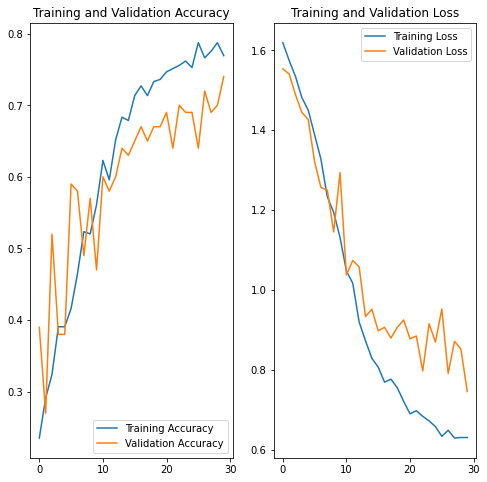

In [14]:
import matplotlib.pyplot as plt

acc = Model_1.history['categorical_accuracy']
val_acc = Model_1.history['val_categorical_accuracy']

loss = Model_1.history['loss']
val_loss = Model_1.history['val_loss']
 
epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()